<a href="https://colab.research.google.com/github/manandraj20/r1testing/blob/master/simulationDataBenchMarking_151674.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Utility

In [ ]:
sc_adata=sc.read_h5ad('/content/drive/MyDrive/sc.h5ad')

In [ ]:
sc_adata=sc_adata.transpose()

In [ ]:
meta=pd.read_csv('/content/drive/MyDrive/meta.tsv',sep='\t')

In [ ]:
cell_type=meta.loc[:,"cluster"][0:10000].to_list()

In [ ]:
sc_adata.obs["celltype_final"]=list(cell_type)

In [ ]:
sc_adata.obs["celltype_final"]

AAACCTGGTACGCACC-1_1823_BA24         Neu-NRGN-II
AAACGGGCACCAGATT-1_1823_BA24                L5/6
AAAGATGAGTCCAGGA-1_1823_BA24    Oligodendrocytes
AAAGATGTCTTGAGGT-1_1823_BA24                 OPC
AAAGCAAGTAATCACC-1_1823_BA24    Oligodendrocytes
                                      ...       
CTGCCTATCTTTACGT-1_4849_BA24                 OPC
CTGCGGAAGGCTATCT-1_4849_BA24              AST-FB
CTGCGGAGTAACGTTC-1_4849_BA24                L2/3
CTGCGGAGTTAAGATG-1_4849_BA24              IN-VIP
CTGCTGTAGGAGCGAG-1_4849_BA24          Neu-NRGN-I
Name: celltype_final, Length: 10000, dtype: object

In [ ]:
type(sc_adata.obs["celltype_final"])

pandas.core.series.Series

In [ ]:
meta.loc[:,"cluster"][0:10000]

0            Neu-NRGN-II
1                   L5/6
2       Oligodendrocytes
3                    OPC
4       Oligodendrocytes
              ...       
9995                 OPC
9996              AST-FB
9997                L2/3
9998              IN-VIP
9999          Neu-NRGN-I
Name: cluster, Length: 10000, dtype: object

#Google Sheet Integration

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

# wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1A-t34WjbWd7Us_yfS-NjhURiAZeWPnN0tEgtLTlNgB8/edit#gid=1075865106').sheet1

# get_all_values gives a list of rows.
# rows = wb.get_all_values()
# print(rows)

# Convert to a DataFrame and render.
# import pandas as pd
# pd.DataFrame.from_records(rows)


In [ ]:
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1A-t34WjbWd7Us_yfS-NjhURiAZeWPnN0tEgtLTlNgB8/edit#gid=1075865106')
wb.worksheets()

[<Worksheet 'sim-destVI' id:1789315306>,
 <Worksheet 'Sim-Cell2Loc expe 0,1 ' id:2012734862>,
 <Worksheet 'sim1' id:1635575913>,
 <Worksheet 'sim5' id:1075865106>,
 <Worksheet 'sim8' id:175004281>,
 <Worksheet 'sim13' id:2100799810>,
 <Worksheet 'sim17' id:2055227097>,
 <Worksheet 'sim18' id:296310779>,
 <Worksheet 'sim21' id:1850306739>,
 <Worksheet 'sim23' id:904684879>,
 <Worksheet 'sim29' id:186041399>]

#Loading libraries

In [5]:
!pip install --quiet scvi-colab
from scvi_colab import install
install()


INFO     scvi-colab: Installing scvi-tools.                                                  
INFO     scvi-colab: Install successful. Testing import.                                     


Global seed set to 0


In [6]:
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib.lines import Line2D
import umap

import scvi
from scvi.model import CondSCVI, DestVI

import torch

%matplotlib inline

#Loading Datasets

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
sc_adata= sc.read_h5ad('/content/drive/MyDrive/sc.h5ad')
sc_adata

AnnData object with n_obs × n_vars = 22617 × 10000

In [8]:
sc_adata=sc_adata.transpose()

In [9]:
st_adata =sc.read_h5ad('/content/drive/MyDrive/st_151674_raw_adata_filtered.h5ad')
st_adata

AnnData object with n_obs × n_vars = 4992 × 22617
    var: 'gene_ids', 'feature_types', 'genome'

In [49]:
st_data=sc.read_10x_h5('/content/drive/MyDrive/151674_raw_feature_bc_matrix.h5')

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [50]:
st_data.obs_names

Index(['AAACAACGAATAGTTC-1', 'AAACAAGTATCTCCCA-1', 'AAACAATCTACTAGCA-1',
       'AAACACCAATAACTGC-1', 'AAACAGAGCGACTCCT-1', 'AAACAGCTTTCAGAAG-1',
       'AAACAGGGTCTATATT-1', 'AAACAGTGTTCCTGGG-1', 'AAACATGGTGAGAGGA-1',
       'AAACATTTCCCGGATT-1',
       ...
       'TTGTTAGCAAATTCGA-1', 'TTGTTCAGTGTGCTAC-1', 'TTGTTCTAGATACGCT-1',
       'TTGTTGGCAATGACTG-1', 'TTGTTGTGTGTCAAGA-1', 'TTGTTTCACATCCAGG-1',
       'TTGTTTCATTAGTCTA-1', 'TTGTTTCCATACAACT-1', 'TTGTTTGTATTACACG-1',
       'TTGTTTGTGTAAATTC-1'],
      dtype='object', length=4992)

#Preprocessing Datasets

In [10]:
G=2000
sc.pp.filter_genes(sc_adata, min_counts=10)

sc_adata.layers["counts"] = sc_adata.X.copy()

sc.pp.highly_variable_genes(
  sc_adata,
    n_top_genes=G,
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)



sc.pp.normalize_total(sc_adata, target_sum=10e4)
sc.pp.log1p(sc_adata)
sc_adata.raw = sc_adata
sc_adata

AnnData object with n_obs × n_vars = 10000 × 2000
    var: 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'
    layers: 'counts'

In [11]:
st_adata.layers["counts"] =st_adata.X.copy()

sc.pp.normalize_total(st_adata, target_sum=10e4)
sc.pp.log1p(st_adata)
st_adata.raw = st_adata

In [12]:
# filter genes to be the same on the spatial data
intersect = np.intersect1d(st_adata.var_names, sc_adata.var_names)
st_adata=st_adata[:,intersect].copy()
sc_adata=sc_adata[:,intersect].copy()


# Fit the scLVM

In [13]:
sc_model=CondSCVI.load('/content/drive/MyDrive/sc_model')

INFO     File /content/drive/MyDrive/sc_model/model.pt already downloaded                    


In [ ]:
CondSCVI.setup_anndata(sc_adata, layer='counts', labels_key='celltype_final')

In [ ]:
sc_model=CondSCVI(sc_adata, weight_obs=True)

In [ ]:
sc_model.train(max_epochs=2500)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 2500/2500: 100%|██████████| 2500/2500 [33:03<00:00,  1.26it/s, loss=1.56e+04, v_num=1]


Conditional SCVI Model with the following params: 
n_hidden: 128, n_latent: 5, n_layers: 2, dropout_rate: 0.05, weight_obs: True
Training status: Trained


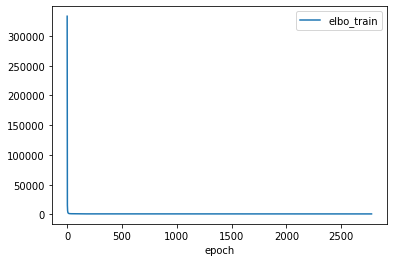

In [19]:
sc_model.history['elbo_train'].plot()

In [ ]:
sc_model.save('./sc_model', overwrite=True, save_anndata=True)

In [ ]:
sc_adata.obsm["X_scVI"]=sc_model.get_latent_representation()

In [ ]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(sc_adata, use_rep="X_scVI")
sc.tl.umap(sc_adata, min_dist=0.3)

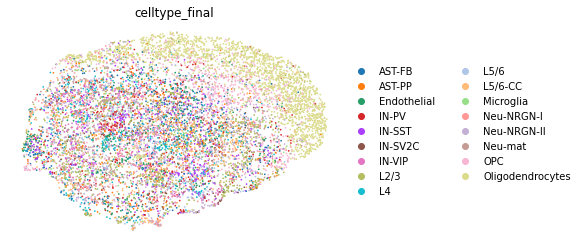

In [ ]:
sc.pl.umap(
    sc_adata,
    color=["celltype_final"],
    frameon=False,
)

# Decconvolution with stLVM

In [14]:
DestVI.setup_anndata(st_adata, layer="counts")
st_model = DestVI.from_rna_model(st_adata, sc_model)
st_model.train(max_epochs=2500)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/2500:   0%|          | 0/2500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scvi/distributions/_negative_binomial.py:102: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /root/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  - lgamma(x + 1)


Epoch 2500/2500: 100%|██████████| 2500/2500 [19:42<00:00,  2.11it/s, loss=5.09e+06, v_num=1]


In [ ]:
st_model.train(max_epochs=2500)

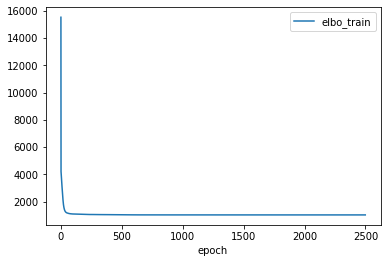

In [15]:
st_model.history['elbo_train'].plot()

In [3]:
%cd /content/drive/MyDrive/


/content/drive/MyDrive


In [16]:
st_model.save('./st_model_151674', overwrite=True, save_anndata=True)

In [17]:
st_model.get_proportions().to_csv("result_151674.csv")

In [21]:
locations= pd.read_csv('/content/drive/MyDrive/tissue_locations_151674.csv', header=None)

Conditional SCVI Model with the following params: 
n_hidden: 128, n_latent: 5, n_layers: 2, dropout_rate: 0.05, weight_obs: True
Training status: Trained
DestVI Model
Training status: Trained


In [33]:
st_adata.obsm["proportions"]=st_model.get_proportions()

In [56]:
locations.sort_index(inplace=True)
locations.index.name=None
st_adata.obsm["spatial"]=locations

In [69]:
ct_list = st_adata.obsm["proportions"].columns
for ct in ct_list:
  data = st_adata.obsm["proportions"][ct].values
  st_adata.obs[ct] = np.clip(data, 0, np.quantile(data, 0.99))

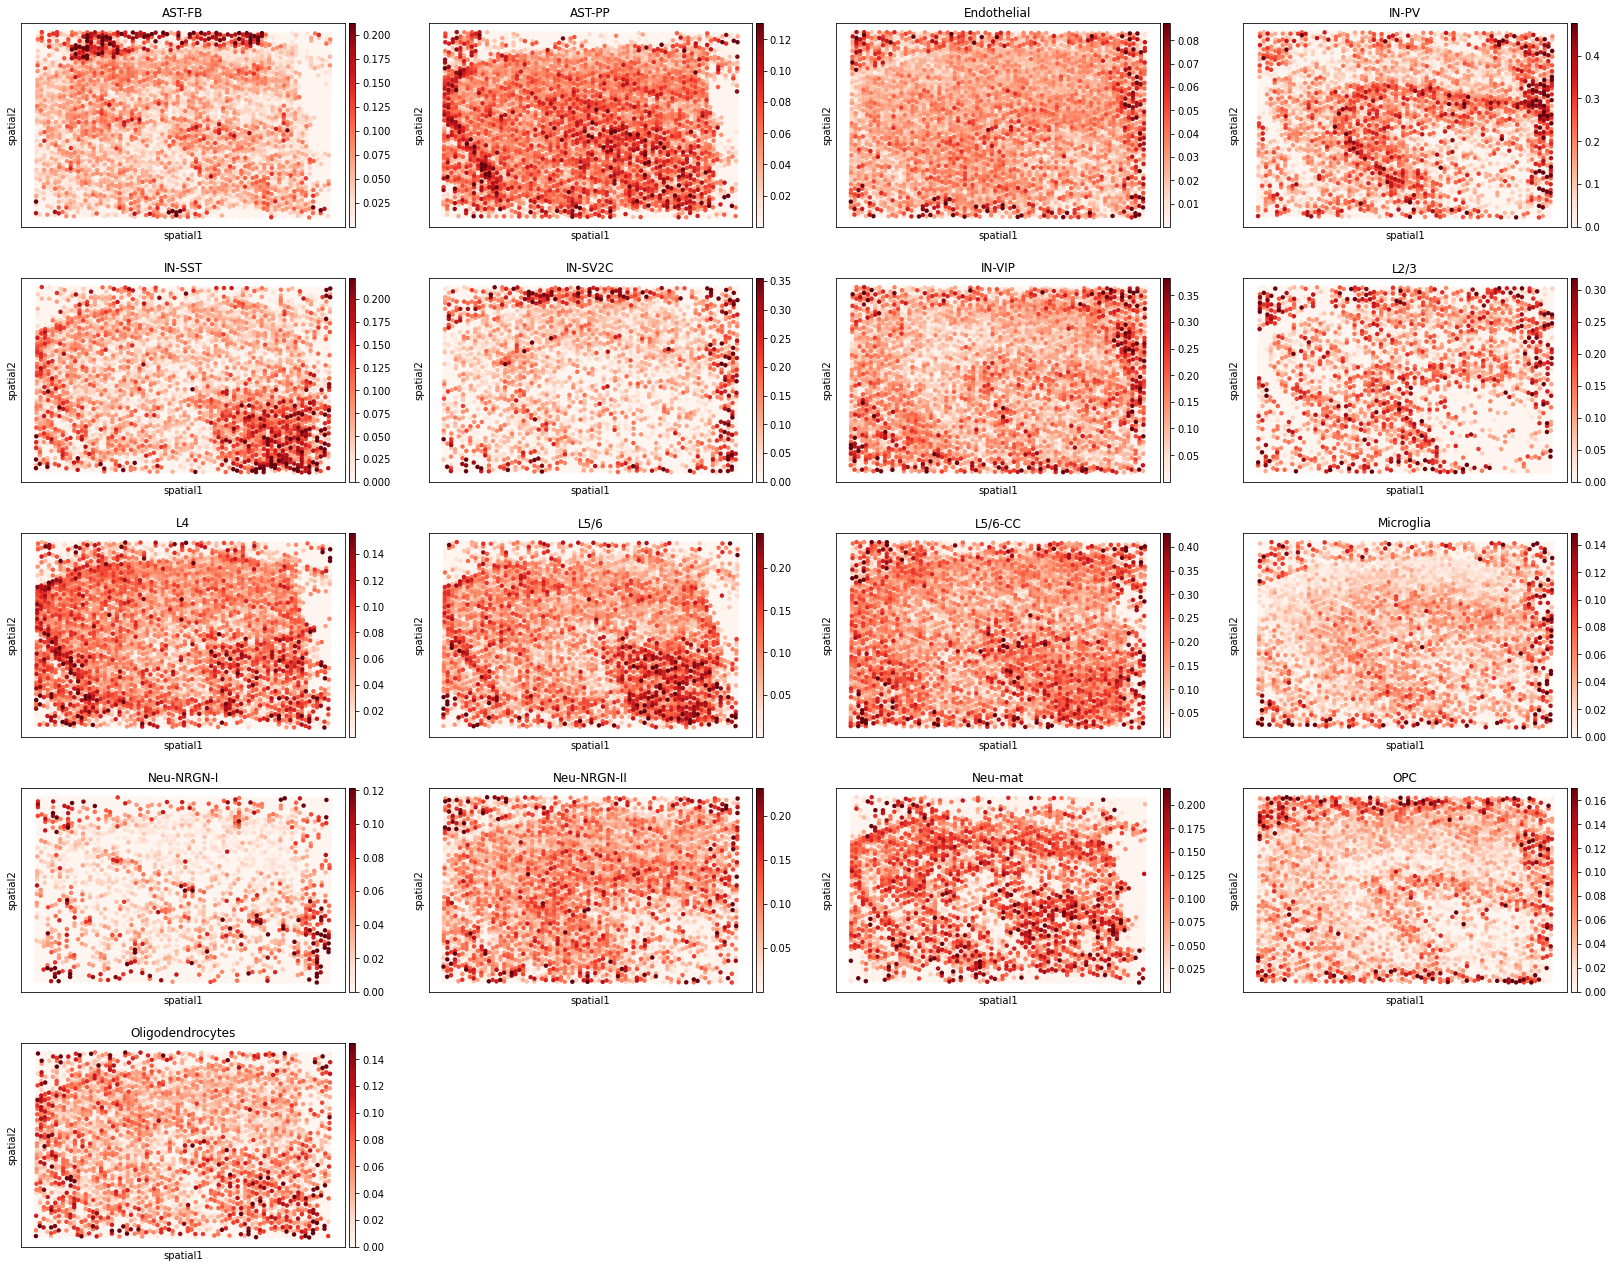

In [70]:
sc.pl.embedding(st_adata, basis="spatial", color=ct_list, cmap='Reds', s=80)

# Cell type Proportions

In [ ]:
Predicted= pd.read_csv('/content/outputSimulatedBenchMarkingData_8.csv')


if "Unnamed: 0" in Predicted.columns:
  Predicted.drop(columns="Unnamed: 0", inplace=True)
Predicted.sort_index(axis=1,inplace=True)
for i in range(len(Predicted)):
    Predicted.iloc[i,:]=Predicted.iloc[i,:]/(Predicted.iloc[i,:].sum())
Predicted


,Connecting Tubule,Distal Convoluted Tubule,Endothelial Cell,Intercalated Cells Type A,Intercalated Cells Type B,Leukocyte,Mesangial Cells,Principal Cells,Proximal Tubule,Thick Ascending Limb
0,0.000384,0.001119,0.003789,0.276747,0.115170,0.020888,0.003615,0.129920,0.156932,0.291436
1,0.009730,0.213666,0.089945,0.012481,0.094942,0.032822,0.101535,0.124844,0.300346,0.019688
2,0.052434,0.095165,0.052899,0.020705,0.012580,0.031217,0.101260,0.101641,0.065480,0.466620
3,0.859011,0.003863,0.016746,0.003166,0.001780,0.002918,0.003208,0.001081,0.100844,0.007383
4,0.000166,0.212224,0.069104,0.062047,0.053600,0.153616,0.197534,0.093900,0.001436,0.156373
...,...,...,...,...,...,...,...,...,...,...
995,0.003774,0.007777,0.731807,0.001934,0.004743,0.002202,0.014770,0.008561,0.217296,0.007136
996,0.172051,0.530734,0.026599,0.008754,0.099200,0.155687,0.001114,0.003139,0.001754,0.000966
997,0.067794,0.062803,0.453561,0.000061,0.038323,0.076089,0.104281,0.177858,0.018323,0.000908
998,0.297159,0.199094,0.022295,0.206512,0.000499,0.008940,0.002669,0.008977,0.129454,0.124402


In [ ]:
Target= pd.DataFrame(st_adata.uns['density'])
if "Unnamed: 0" in Target.columns:
  Target.drop(columns="Unnamed: 0", inplace=True)
Target.sort_index(axis=1,inplace=True)
for i in range(len(Target)):
    Target.loc[i,:]=Target.loc[i,:]/Target.loc[i,:].sum()
Target

,Connecting Tubule,Distal Convoluted Tubule,Endothelial Cell,Intercalated Cells Type A,Intercalated Cells Type B,Leukocyte,Mesangial Cells,Principal Cells,Proximal Tubule,Thick Ascending Limb
0,0.000000,0.000000,0.000000,0.333333,0.0,0.0,0.0,0.111111,0.555556,0.000000
1,0.000000,0.153846,0.000000,0.153846,0.0,0.0,0.0,0.000000,0.384615,0.307692
2,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.142857,0.857143,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.000000
4,0.000000,0.000000,0.375000,0.000000,0.0,0.0,0.0,0.375000,0.250000,0.000000
...,...,...,...,...,...,...,...,...,...,...
995,0.000000,0.000000,0.250000,0.000000,0.0,0.0,0.0,0.000000,0.750000,0.000000
996,0.555556,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.222222,0.222222
997,0.000000,0.000000,0.200000,0.000000,0.0,0.0,0.0,0.500000,0.300000,0.000000
998,0.000000,0.000000,0.357143,0.000000,0.0,0.0,0.0,0.000000,0.642857,0.000000


#Evaluation

In [ ]:
import numpy as np
import pandas as pd
import scipy
from scipy.spatial import distance
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from scipy.special import rel_entr
import math
from scipy.stats import wasserstein_distance

In [ ]:
Target=Target.to_numpy()
Predicted=Predicted.to_numpy()

##Pearson Correlation

In [ ]:
num_celltypes=Predicted.shape[1]
d = np.zeros(num_celltypes)
for i in range(0,num_celltypes):
    p=Predicted[:,i]
    t=Target[:,i]
    prs=(np.corrcoef(p,t,rowvar=False))
    d[i]=prs[0,1]

In [ ]:
np.mean(np.nan_to_num(d))

-0.008491530147058873

In [ ]:
pd.DataFrame(d)

,0
0,0.002304
1,-0.001701
2,-0.064143
3,0.070275
4,-0.013647
5,-0.029027
6,0.052948
7,-0.020104
8,-0.020030
9,-0.061790


In [ ]:
prs= [["Pearson correlation DestVI"]]+pd.DataFrame(d).fillna("").to_numpy().tolist()
ws=wb.worksheet("sim8")
ws.update("U1",prs)


{'spreadsheetId': '1A-t34WjbWd7Us_yfS-NjhURiAZeWPnN0tEgtLTlNgB8',
 'updatedCells': 11,
 'updatedColumns': 1,
 'updatedRange': "'sim8'!U1:U11",
 'updatedRows': 11}

## Jenson Shannon Divergence

In [ ]:
from math import nan
from scipy.spatial import distance
JensenDistance=distance.jensenshannon(Predicted,Target)

In [ ]:
JensenDistance =JensenDistance[~np.isnan(JensenDistance)]
np.mean(JensenDistance)
ws.update("D12",[[str(np.mean(JensenDistance))]])

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'spreadsheetId': '1A-t34WjbWd7Us_yfS-NjhURiAZeWPnN0tEgtLTlNgB8',
 'updatedCells': 1,
 'updatedColumns': 1,
 'updatedRange': "'sim5'!D12",
 'updatedRows': 1}

## F1 Score, Precision, Recall

In [ ]:
thresholds={0.001,0.01,0.1,0.2,0.3}

In [ ]:
d = pd.DataFrame(0, index=np.arange(len(thresholds)), columns=["Threshold","F1-score","Precision","Recall"])

d.index=thresholds
for t in thresholds:
    Predicted_logical=(Predicted>t).astype(int)
    Target_logical=(Target>t).astype(int)
    d.loc[t,"Precision"]=precision_score(Target_logical,Predicted_logical,average="micro")
    d.loc[t,"Recall"]=recall_score(Target_logical,Predicted_logical,average="micro")
    d.loc[t,"F1-score"]=f1_score(Target_logical,Predicted_logical,average="micro")
d["Threshold"]=d.index
d.fillna("")

,Threshold,F1-score,Precision,Recall
0.100,0.100,0.415365,0.522665,0.344616
0.300,0.300,0.371847,0.501096,0.295602
0.200,0.200,0.406689,0.582051,0.312529
0.010,0.010,0.399187,0.347408,0.469102
0.001,0.001,0.406569,0.319828,0.557870


In [ ]:
eval= [d.columns.tolist()]+d.to_numpy().tolist()
ws.update('M24',eval)

{'spreadsheetId': '1A-t34WjbWd7Us_yfS-NjhURiAZeWPnN0tEgtLTlNgB8',
 'updatedCells': 24,
 'updatedColumns': 4,
 'updatedRange': "'sim5'!M24:P29",
 'updatedRows': 6}

## KL Divergence

In [ ]:
kldiv=[]
for i in range(Predicted.shape[0]):
    to_be_changed=(Predicted[i,:]<=0)
    pred=Predicted[i,:]
    pred[to_be_changed]=1e-50
    target=Target[i,:]
    
  
    kl=scipy.special.rel_entr(target,pred)
    kldiv.append(kl.sum())

In [ ]:
ws.update("C5", [[str(sum(kldiv)/len(kldiv))]])

{'spreadsheetId': '1A-t34WjbWd7Us_yfS-NjhURiAZeWPnN0tEgtLTlNgB8',
 'updatedCells': 1,
 'updatedColumns': 1,
 'updatedRange': "'sim8'!C5",
 'updatedRows': 1}

## Wasserstein Distance

In [ ]:
scipy.stats.wasserstein_distance(np.reshape(Target,(Target.shape[0]*Target.shape[1])),np.reshape(Predicted,(Predicted.shape[0]*Predicted.shape[1])))

nan

##Plotting


In [ ]:
st_model=DestVI.load('/content/drive/MyDrive/st_model_151672')

INFO     File /content/drive/MyDrive/st_model_151673/model.pt already downloaded             


In [ ]:
st_model

DestVI Model
Training status: Trained


In [ ]:
st_adata=sc.read_h5ad('/content/drive/MyDrive/st_model_151672/')

OSError: ignored

In [ ]:
st_adata

AnnData object with n_obs × n_vars = 3639 × 2000
    obs: '_indices'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p'
    layers: 'counts'